# Feature Engineering
**Project Assumption:** The target model is SVM

### Table of Contents
1. Data Loading
    - 1.1 Library Import
    - 1.2 Data Loading
2. Data Preprocessing & Cleaning
    - 2.1 Target Feature Encoding
    - 2.2 Global Categorical Formatting
3. Feature Selection
    - 3.1 Initial Feature Dropping
    - 3.2 Handling Colinear Features
4. Feature Construction
    - 4.1 Consolidation
    - 4.2 Categorical Grouping
    - 4.3 Oridinal Encoding
5. Data Scaling
6. Encoding Categorical Features
7. Final Pipeline

## 1. Data Loading

### 1.1 Library Import

In [ ]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np

### 1.2 Data Loading

In [2]:
train_table = pq.read_table('data/train.parquet').to_pandas()
y_train = train_table['income_50k']
X_train = train_table.drop(columns=['income_50k'])

## 2. Data Preprocessing & Cleaning

### 2.1 Target Feature Encoding

In [3]:
mapping = {
    "' - 50000.'": 0,
    "' 50000+.'": 1
}

y_train = y_train.map(mapping)

### 2.2 Global Categorical Formatting

In [4]:
cat_columns = X_train.select_dtypes(include=['object']).columns

for col in cat_columns:
    X_train[col] = X_train[col].str.replace("'", "", regex=False).str.strip()

## 3. Feature Selection

### 3.1 Initial Feature Dropping

In [5]:
X_train = X_train.drop(columns=['race', 'sex', 'hisp_origin', 'vet_question', 'unemp_reason', 'year', 'unknown', 'mig_prev_sunbelt', 'det_ind_code', 'det_occ_code', 'own_or_self', 'vet_benefits', 'state_prev_res', 'region_prev_res'])

### 3.2 Handling Collinear Features

array([[<Axes: title={'center': 'num_emp'}>,
        <Axes: title={'center': 'weeks_worked'}>]], dtype=object)

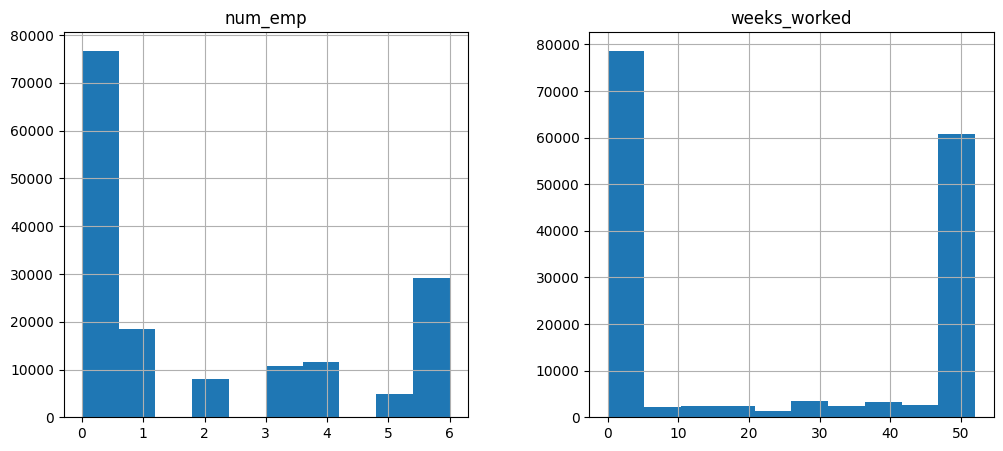

In [6]:
X_train[['num_emp', 'weeks_worked']].hist(layout=(1, 2), figsize=(12, 5))

In [7]:
corelation = X_train['num_emp'].corr(X_train['weeks_worked'])
print(corelation)

0.7473200400410593


In [8]:
temp_df = pd.concat([X_train[['num_emp', 'weeks_worked']], y_train], axis=1)

corelation = temp_df.corr()['income_50k']
print(corelation)

num_emp         0.220870
weeks_worked    0.260935
income_50k      1.000000
Name: income_50k, dtype: float64


Although `num_emp` and `weeks_worked` show a high mutual correlation of 0.75, an analysis of their correlation with the target variable income_50k indicates that both features hold predictive power. Simply removing one variable might result in information loss.

To address this, I will introduce an interaction feature. The hypothesis is that the combination of employer size and the duration of employment (e.g., working a full year at a large corporation) provides a stronger signal for high income than either variable individually.

In [9]:
X_train['company_tenure_interaction'] = X_train['num_emp'] * X_train['weeks_worked']

correlation_comparison = X_train[['num_emp', 'weeks_worked', 'company_tenure_interaction']].corrwith(y_train)
print(correlation_comparison)

num_emp                       0.220870
weeks_worked                  0.260935
company_tenure_interaction    0.252995
dtype: float64


The experimental interaction feature `company_tenure_interaction` resulted in a correlation coefficient of 0.25, which does not outperform the standalone `weeks_worked` feature (0.26).

Since the engineered feature did not provide a stronger linear signal, I have decided to discard it and retain the original features: `num_emp` and `weeks_worked`. Although these variables exhibit multicollinearity (0.75), I choose to accept this redundancy to avoid losing any granular information contained in the individual features.


In [10]:
X_train.drop(columns=['company_tenure_interaction'], inplace=True)

## 4. Feature Construction

### 4.1 Consolidation

4.1.1 `is_mig_universe`

In [11]:
migration_cols = ['mig_chg_reg', 'mig_move_reg', 'mig_chg_msa']
X_train['is_mig_universe'] = (X_train[migration_cols] == "Not in universe").all(axis=1).astype(int)
X_train = X_train.drop(columns=migration_cols)

To validate the `is_mig_universe` flag, I present two visualizations:

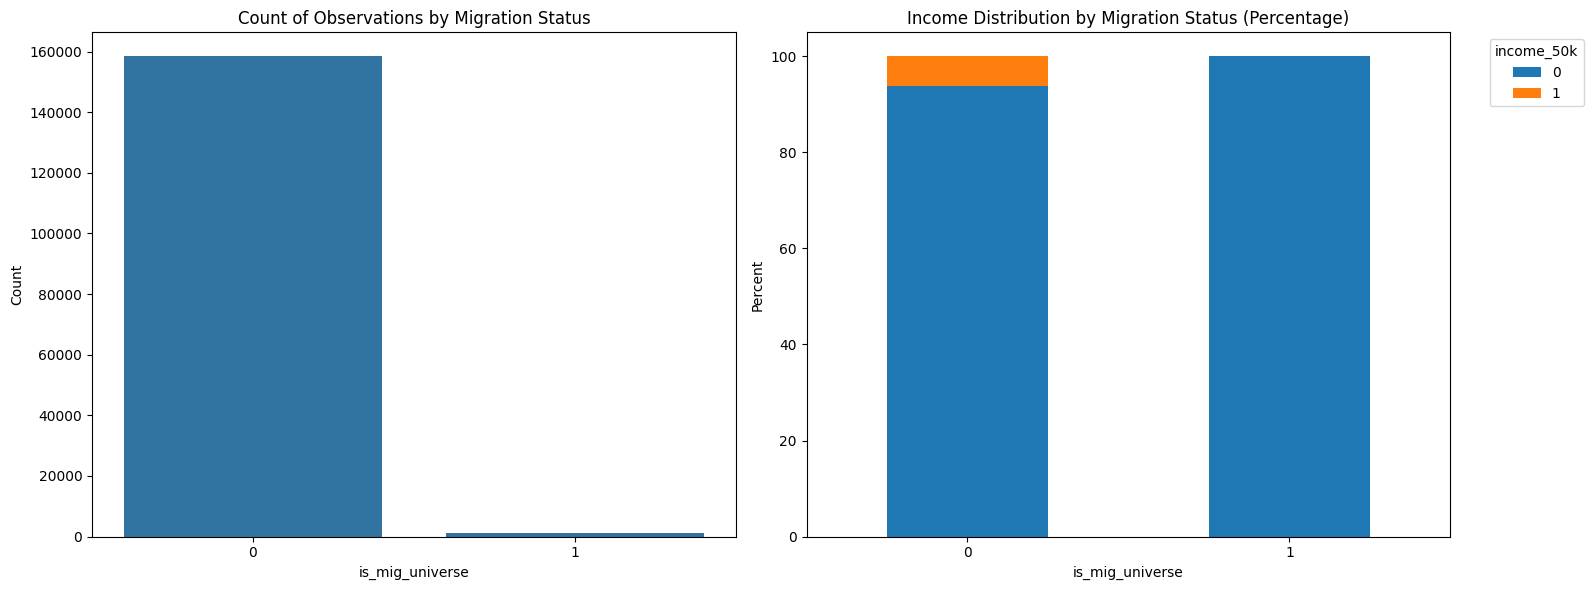

In [12]:
temp_plot_df = X_train.copy()
temp_plot_df['income_50k'] = y_train

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=temp_plot_df, x='is_mig_universe', ax=axes[0])
axes[0].set_title('Count of Observations by Migration Status')
axes[0].set_ylabel('Count')

crosstab = pd.crosstab(temp_plot_df['is_mig_universe'], temp_plot_df['income_50k'])
crosstab_norm = crosstab.div(crosstab.sum(1), axis=0) * 100

crosstab_norm.plot(kind='bar', stacked=True, ax=axes[1], rot=0)
axes[1].set_title('Income Distribution by Migration Status (Percentage)')
axes[1].set_ylabel('Percent')
axes[1].set_xlabel('is_mig_universe')
axes[1].legend(title='income_50k', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 4.1.2 `is_child`

In [13]:
X_train['is_child'] = (X_train['fam_under_18'] != "Not in universe").astype(int)

To validate the `is_child` flag, I present two visualizations:

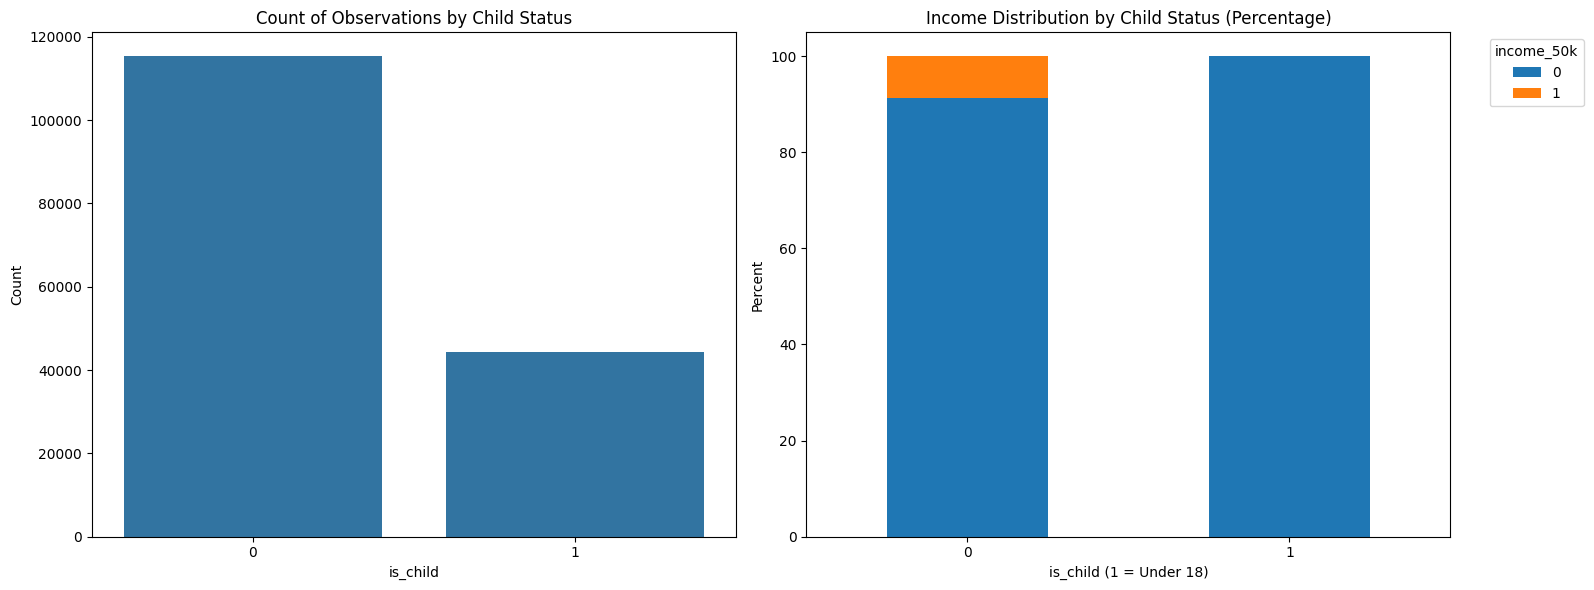

In [14]:
temp_plot_df = X_train.copy()
temp_plot_df['income_50k'] = y_train

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=temp_plot_df, x='is_child', ax=axes[0])
axes[0].set_title('Count of Observations by Child Status')
axes[0].set_ylabel('Count')

crosstab = pd.crosstab(temp_plot_df['is_child'], temp_plot_df['income_50k'])
crosstab_norm = crosstab.div(crosstab.sum(1), axis=0) * 100

crosstab_norm.plot(kind='bar', stacked=True, ax=axes[1], rot=0)
axes[1].set_title('Income Distribution by Child Status (Percentage)')
axes[1].set_ylabel('Percent')
axes[1].set_xlabel('is_child (1 = Under 18)')
axes[1].legend(title='income_50k', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
X_train = X_train.drop(columns=['fam_under_18'])

### 4.1.3 `is_family_match`

In [16]:
X_train['is_family_match'] = ((X_train['country_father'] == X_train['country_mother']) & (X_train['country_mother'] == X_train['country_self'])).astype(int)


By consolidating this complex information into the single is_family_match binary flag (bottom-right), we reduce dimensionality and provide a clearer signal to the model about the individual's generational background.

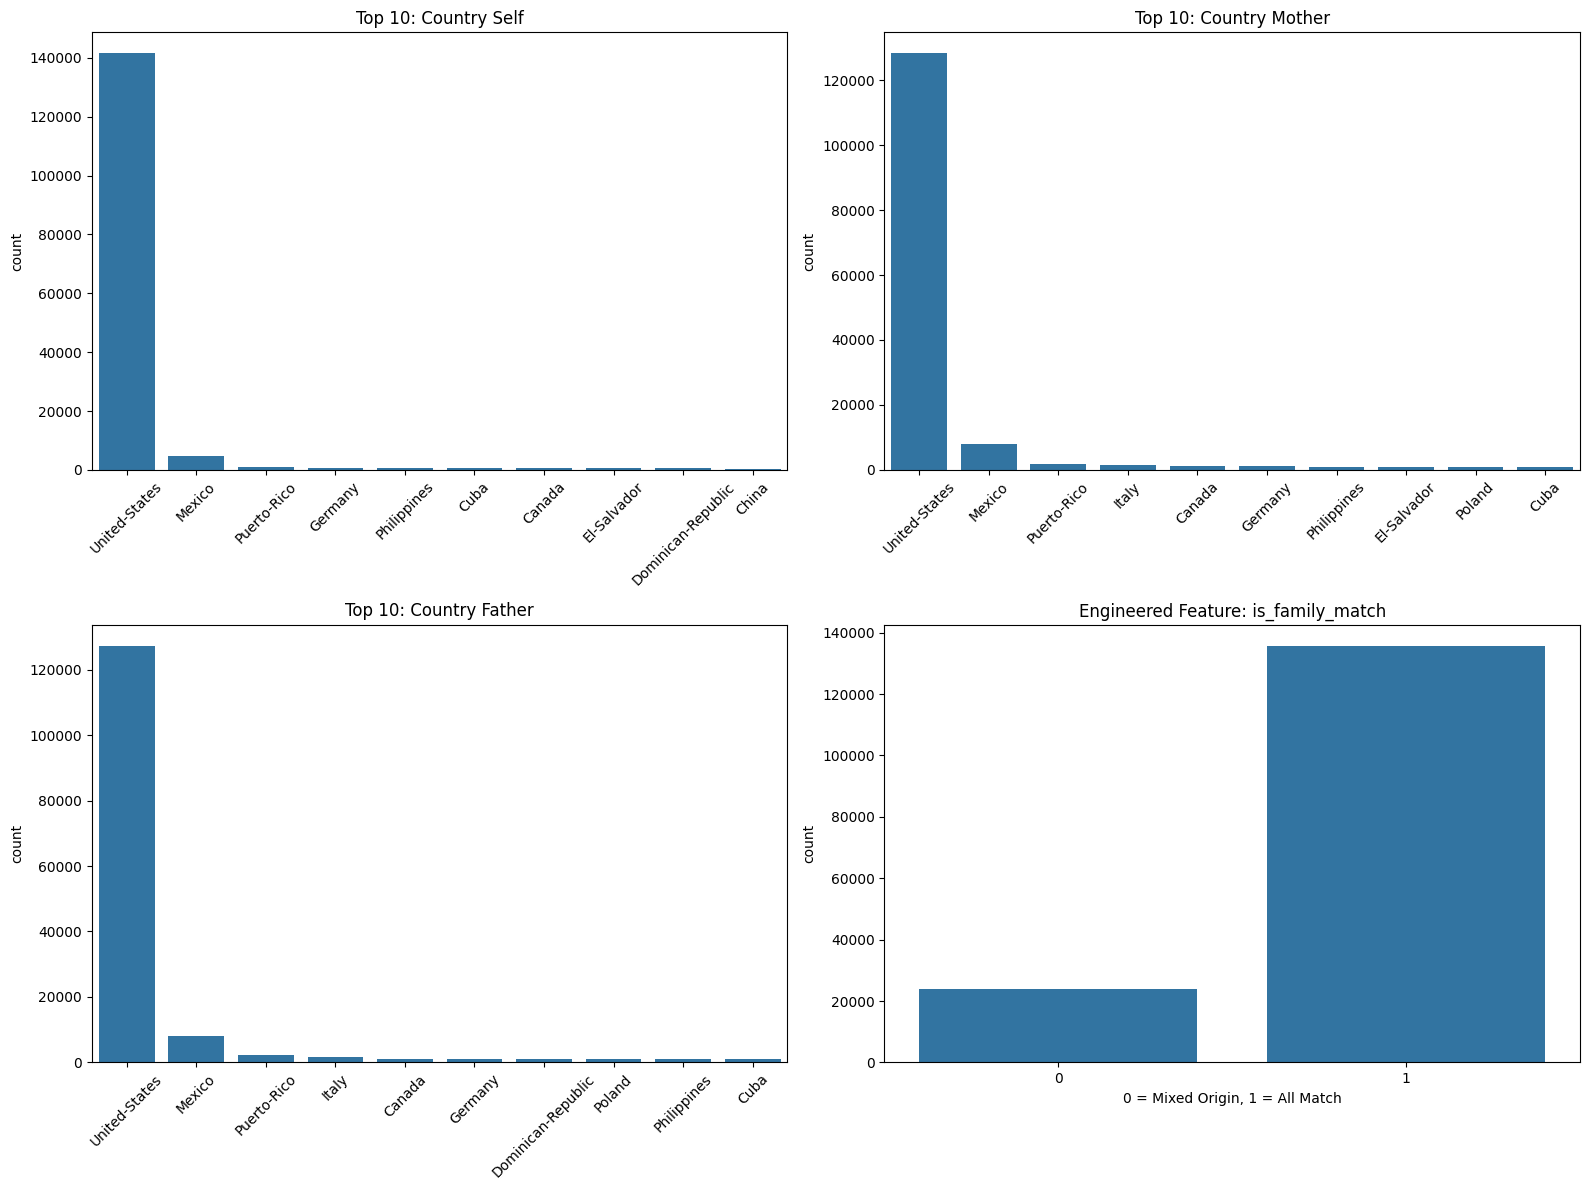

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

def plot_top_10(df, col, ax, title):
    top_10 = df[col].value_counts().nlargest(10).index
    sns.countplot(data=df[df[col].isin(top_10)], x=col, order=top_10, ax=ax)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')

plot_top_10(X_train, 'country_self', axes[0, 0], 'Top 10: Country Self')
plot_top_10(X_train, 'country_mother', axes[0, 1], 'Top 10: Country Mother')
plot_top_10(X_train, 'country_father', axes[1, 0], 'Top 10: Country Father')

sns.countplot(data=X_train, x='is_family_match', ax=axes[1, 1])
axes[1, 1].set_title('Engineered Feature: is_family_match')
axes[1, 1].set_xlabel('0 = Mixed Origin, 1 = All Match')

plt.tight_layout()
plt.show()

In [18]:
X_train.drop(columns=['country_father', 'country_mother', 'country_self'], inplace=True)

### 4.1.4  `net_capital` and `is_investor`

In [19]:
X_train['net_capital'] = X_train['capital_gains'] - X_train['capital_losses']
X_train['is_investor'] = ((X_train['capital_gains'] > 0) | (X_train['capital_losses'] > 0)).astype(int)

Insights from EDA revealed that `capital_gains` and `capital_losses` exhibit near-zero correlation. This indicates that these events are mutually exclusive—individuals typically report either a gain or a loss, but rarely both simultaneously.

Consequently, we can safely consolidate these two sparse variables into a single continuous feature, `net_capital` (calculated as Gains - Losses), without losing information.

To further assist the model in navigating the high sparsity of this data (where most values are zero), I will also introduce a binary flag, `is_investor`. This explicitly marks individuals with active financial involvement, helping the model distinguish them from the general population.

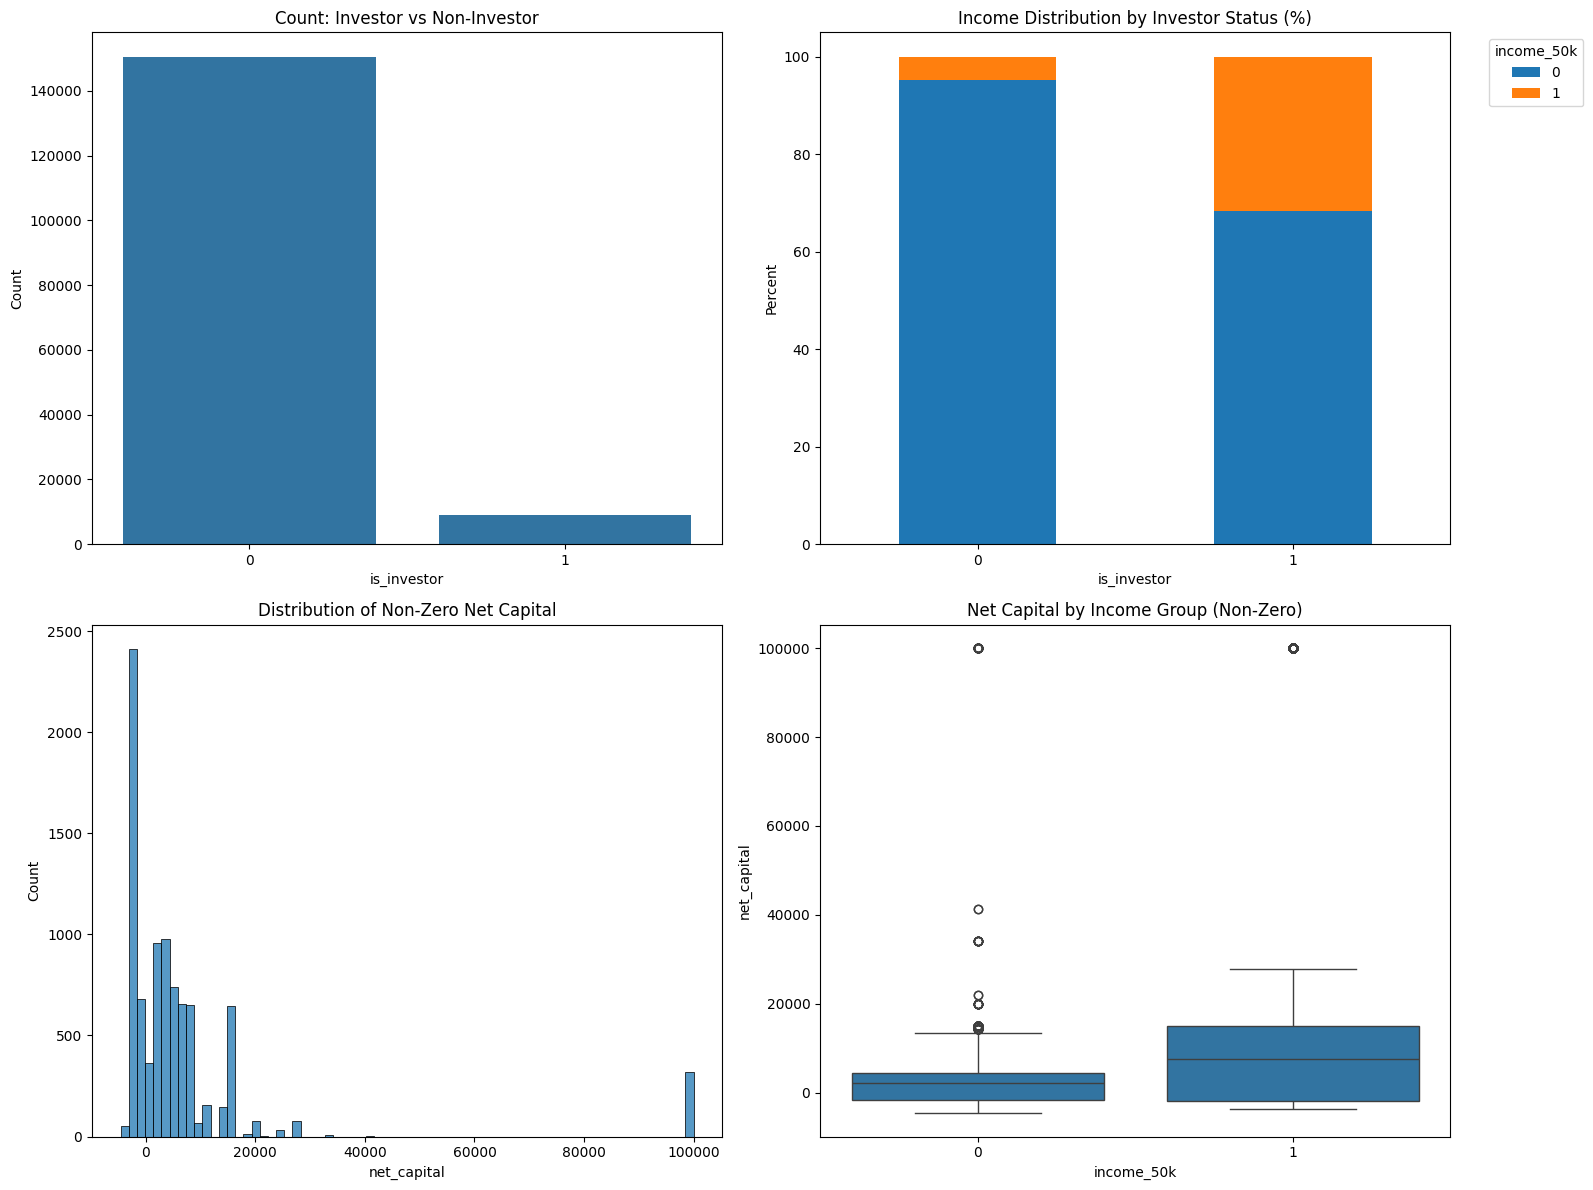

In [20]:
temp_plot_df = X_train.copy()
temp_plot_df['income_50k'] = y_train

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.countplot(data=temp_plot_df, x='is_investor', ax=axes[0, 0])
axes[0, 0].set_title('Count: Investor vs Non-Investor')
axes[0, 0].set_ylabel('Count')

crosstab = pd.crosstab(temp_plot_df['is_investor'], temp_plot_df['income_50k'])
crosstab_norm = crosstab.div(crosstab.sum(1), axis=0) * 100
crosstab_norm.plot(kind='bar', stacked=True, ax=axes[0, 1], rot=0)
axes[0, 1].set_title('Income Distribution by Investor Status (%)')
axes[0, 1].set_ylabel('Percent')
axes[0, 1].legend(title='income_50k', bbox_to_anchor=(1.05, 1), loc='upper left')

net_cap_nonzero = temp_plot_df[temp_plot_df['net_capital'] != 0]

sns.histplot(data=net_cap_nonzero, x='net_capital', ax=axes[1, 0], bins=70, color='#1f77b4')
axes[1, 0].set_title('Distribution of Non-Zero Net Capital')
axes[1, 0].set_ylabel('Count')

sns.boxplot(data=net_cap_nonzero, x='income_50k', y='net_capital', ax=axes[1, 1])
axes[1, 1].set_title('Net Capital by Income Group (Non-Zero)')

plt.tight_layout()
plt.show()

In [21]:
X_train = X_train.drop(columns=['capital_gains','capital_losses'])

### 4.2 Categorical Grouping

### 4.2.1 `major_ind_code`, `major_occ_code`

In [22]:
def group_industry(x):
    high_yield = ["Mining", "Finance insurance and real estate", "Public administration", "Communications", "Manufacturing-durable goods"]
    low_yield = ["Retail trade", "Personal services except private HH", "Agriculture", "Private household services", "Wholesale trade", "Forestry and fisheries", "Entertainment"]
    
    if x in high_yield:
        return 'High_Yield'
    elif x in low_yield:
        return 'Low_Yield'
    else:
        return 'Average_Yield'

def group_occupation(x):
    high_income = ["Executive admin and managerial", "Professional specialty"]
    mid_income = ["Sales", "Protective services", "Technicians and related support", "Precision production craft & repair"]
    low_income = ["Machine operators assmblrs & inspctrs", "Transportation and material moving", "Farming forestry and fishing", "Handlers equip cleaners etc", "Adm support including clerical"]
    
    if x in high_income:
        return 'High_Income'
    elif x in mid_income:
        return 'Mid_Income'
    elif x in low_income:
        return 'Low_Income'
    else:
        return 'Minimal_Income'

X_train['industry_group'] = X_train['major_ind_code'].apply(group_industry)

X_train['occupation_group'] = X_train['major_occ_code'].apply(group_occupation)

The following visualizations confirm that the grouping strategy successfully retains the predictive signal while drastically reducing dimensionality.

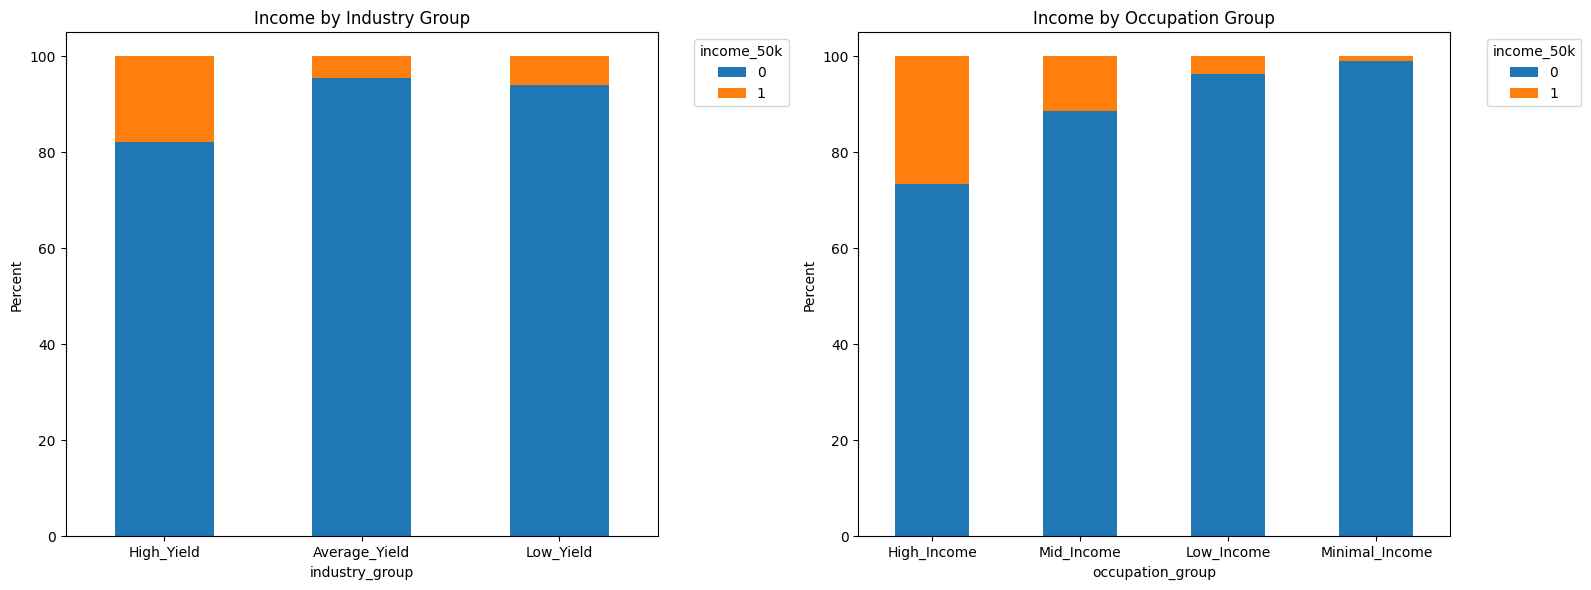

In [23]:
temp_plot_df = X_train.copy()
temp_plot_df['income_50k'] = y_train

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

crosstab_ind = pd.crosstab(temp_plot_df['industry_group'], temp_plot_df['income_50k'])
crosstab_ind_norm = crosstab_ind.div(crosstab_ind.sum(1), axis=0) * 100

order_ind = ['High_Yield', 'Average_Yield', 'Low_Yield']
crosstab_ind_norm.loc[order_ind].plot(kind='bar', stacked=True, ax=axes[0], rot=0, color=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Income by Industry Group')
axes[0].set_ylabel('Percent')
axes[0].legend(title='income_50k', bbox_to_anchor=(1.05, 1), loc='upper left')


crosstab_occ = pd.crosstab(temp_plot_df['occupation_group'], temp_plot_df['income_50k'])
crosstab_occ_norm = crosstab_occ.div(crosstab_occ.sum(1), axis=0) * 100

order_occ = ['High_Income', 'Mid_Income', 'Low_Income', 'Minimal_Income']
crosstab_occ_norm.loc[order_occ].plot(kind='bar', stacked=True, ax=axes[1], rot=0, color=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Income by Occupation Group')
axes[1].set_ylabel('Percent')
axes[1].legend(title='income_50k', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [24]:
X_train.drop(columns=['major_ind_code', 'major_occ_code'], inplace=True)

### 4.2.2 `class_worker`, `full_or_part_emp`

In [25]:
def group_schedule(x):
    if x == "Full-time schedules":
        return 'Full-Time'
    elif "PT" in x: 
        return 'Part-Time'
    elif x in ["Not in labor force", "Unemployed full-time", "Unemployed part-time"]:
        return 'Inactive'
    else:
        return 'Children/Other'

def group_class_worker(x):
    if x in ["Never worked", "Without pay", "Not in universe"]:
        return 'Non-Active'
    elif x in ["Local government", "State government"]:
        return 'State-Local-Gov'
    else:
        return x
X_train['schedule_group'] = X_train['full_or_part_emp'].apply(group_schedule)
X_train['class_group'] = X_train['class_worker'].apply(group_class_worker)


print("Schedule Groups:", X_train['schedule_group'].unique())
print("Worker Class Groups:", X_train['class_group'].unique())

Schedule Groups: ['Children/Other' 'Inactive' 'Full-Time' 'Part-Time']
Worker Class Groups: ['Non-Active' 'Private' 'Self-employed-not incorporated' 'State-Local-Gov'
 'Self-employed-incorporated' 'Federal government']


The following visualizations confirm that the grouping strategy successfully retains the predictive signal while drastically reducing dimensionality.

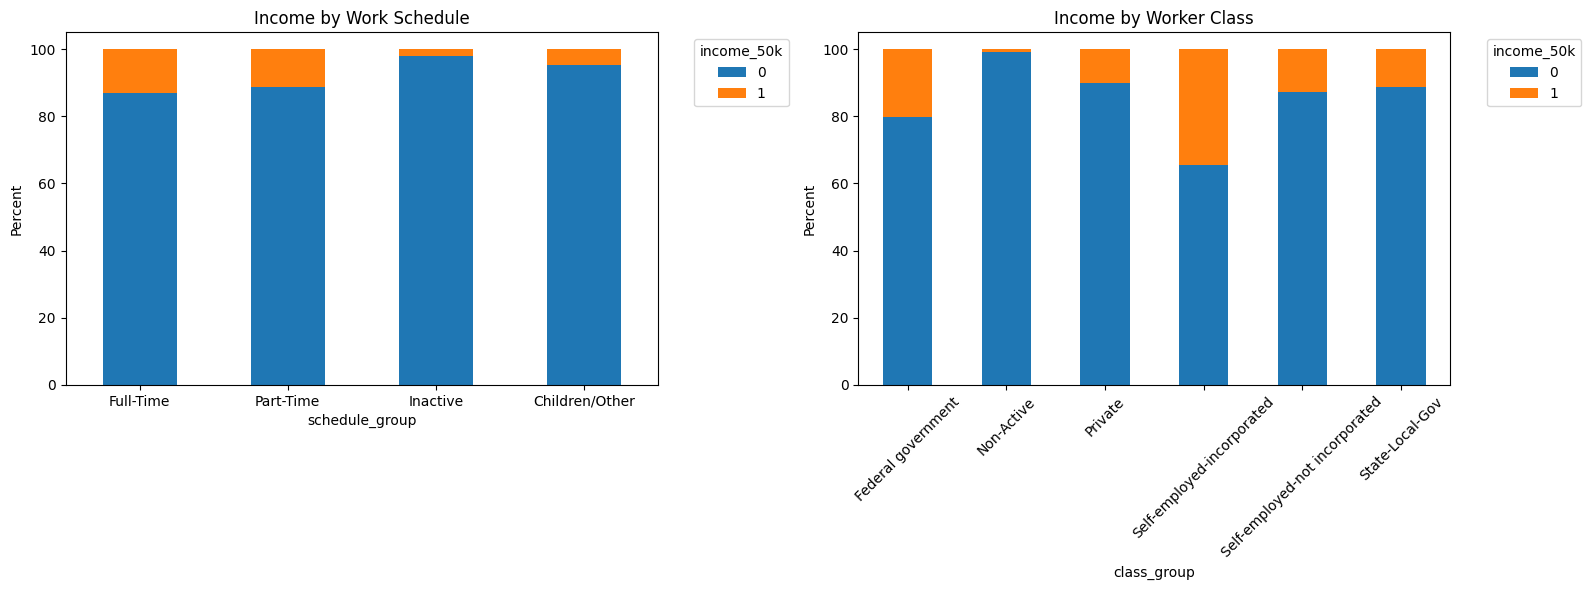

In [26]:
temp_plot_df = X_train.copy()
temp_plot_df['income_50k'] = y_train

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

crosstab_sched = pd.crosstab(temp_plot_df['schedule_group'], temp_plot_df['income_50k'])
crosstab_sched_norm = crosstab_sched.div(crosstab_sched.sum(1), axis=0) * 100
order_sched = ['Full-Time', 'Part-Time', 'Inactive', 'Children/Other']
crosstab_sched_norm.loc[order_sched].plot(kind='bar', stacked=True, ax=axes[0], rot=0, color=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Income by Work Schedule')
axes[0].set_ylabel('Percent')
axes[0].legend(title='income_50k', bbox_to_anchor=(1.05, 1), loc='upper left')

crosstab_class = pd.crosstab(temp_plot_df['class_group'], temp_plot_df['income_50k'])
crosstab_class_norm = crosstab_class.div(crosstab_class.sum(1), axis=0) * 100
crosstab_class_norm.plot(kind='bar', stacked=True, ax=axes[1], rot=45, color=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Income by Worker Class')
axes[1].set_ylabel('Percent')
axes[1].legend(title='income_50k', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
X_train.drop(columns=['full_or_part_emp', 'class_worker'], inplace=True)

### 4.2.3 `det_hh_fam_stat`, `det_hh_summ`

In [28]:
def group_household(x):
    if 'Householder' in x:
        return 'Householder'
    elif 'Spouse of householder' in x:
        return 'Spouse'
    else:
        return 'Dependent'

X_train['household_role'] = X_train['det_hh_fam_stat'].apply(group_household)

print("Household Roles:", X_train['household_role'].unique())

Household Roles: ['Dependent' 'Householder' 'Spouse']


The following visualizations confirm that the grouping strategy successfully retains the predictive signal while drastically reducing dimensionality.

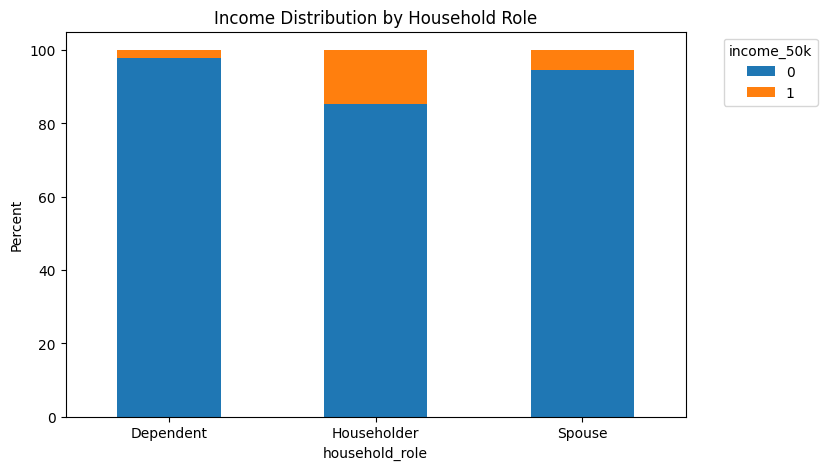

In [29]:
temp_plot_df = X_train.copy()
temp_plot_df['income_50k'] = y_train

crosstab = pd.crosstab(temp_plot_df['household_role'], temp_plot_df['income_50k'])
crosstab_norm = crosstab.div(crosstab.sum(1), axis=0) * 100

ax = crosstab_norm.plot(kind='bar', stacked=True, figsize=(8, 5), rot=0, color=['#1f77b4', '#ff7f0e'])
plt.title('Income Distribution by Household Role')
plt.ylabel('Percent')
plt.legend(title='income_50k', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [30]:
X_train.drop(columns=['det_hh_fam_stat', 'det_hh_summ'], inplace=True)

### 4.2.4 `citizenship`

In [31]:
def group_citizenship(x):
    if x == 'Foreign born- U S citizen by naturalization':
        return 'Naturalized'
    elif x == 'Foreign born- Not a citizen of U S':
        return 'Non-Citizen'
    else:
        return 'US Native'

X_train['citizenship_group'] = X_train['citizenship'].apply(group_citizenship)

The following visualizations confirm that the grouping strategy successfully retains the predictive signal while drastically reducing dimensionality.

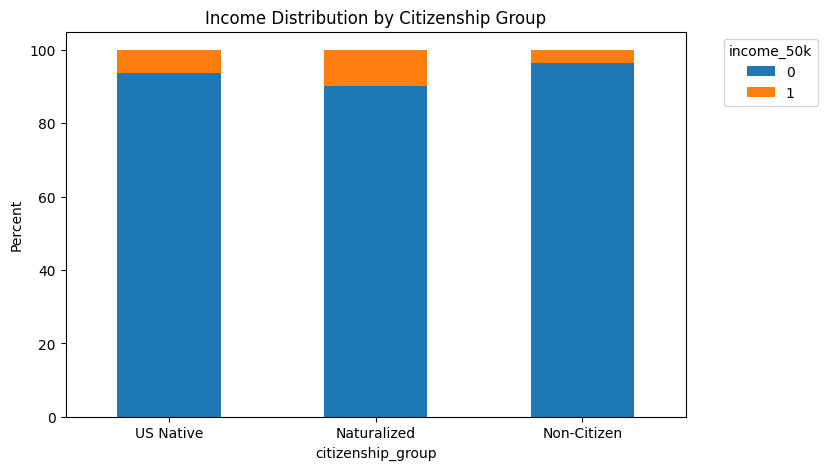

In [32]:
temp_plot_df = X_train.copy()
temp_plot_df['income_50k'] = y_train

crosstab = pd.crosstab(temp_plot_df['citizenship_group'], temp_plot_df['income_50k'])
crosstab_norm = crosstab.div(crosstab.sum(1), axis=0) * 100
order_cit = ['US Native', 'Naturalized', 'Non-Citizen']

ax = crosstab_norm.loc[order_cit].plot(kind='bar', stacked=True, figsize=(8, 5), rot=0, color=['#1f77b4', '#ff7f0e'])
plt.title('Income Distribution by Citizenship Group')
plt.ylabel('Percent')
plt.legend(title='income_50k', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [33]:
X_train.drop(columns=['citizenship'], inplace=True)

## 4.3 Ordinal Encoding

Based on the EDA, the `education` feature represents a clear hierarchy.

In [34]:
X_train['education'].unique()

array(['Children', 'Bachelors degree(BA AB BS)', 'High school graduate',
       '7th and 8th grade', '10th grade',
       'Associates degree-occup /vocational',
       'Associates degree-academic program',
       'Masters degree(MA MS MEng MEd MSW MBA)', '11th grade',
       '1st 2nd 3rd or 4th grade', '9th grade',
       'Some college but no degree', 'Doctorate degree(PhD EdD)',
       '5th or 6th grade', '12th grade no diploma',
       'Prof school degree (MD DDS DVM LLB JD)', 'Less than 1st grade'],
      dtype=object)

In [35]:
education_map = {
    "Children": 0,
    "Less than 1st grade": 1,
    "1st 2nd 3rd or 4th grade": 2,
    "5th or 6th grade": 3,
    "7th and 8th grade": 4,
    "9th grade": 5,
    "10th grade": 6,
    "11th grade": 7,
    "12th grade no diploma": 8,
    "High school graduate": 9,
    "Some college but no degree": 10,
    "Associates degree-occup /vocational": 11,
    "Associates degree-academic program": 12,
    "Bachelors degree(BA AB BS)": 13,
    "Masters degree(MA MS MEng MEd MSW MBA)": 14,
    "Prof school degree (MD DDS DVM LLB JD)": 15,
    "Doctorate degree(PhD EdD)": 16
}

X_train['education'] = X_train['education'].map(education_map)

## 5. Data Scaling

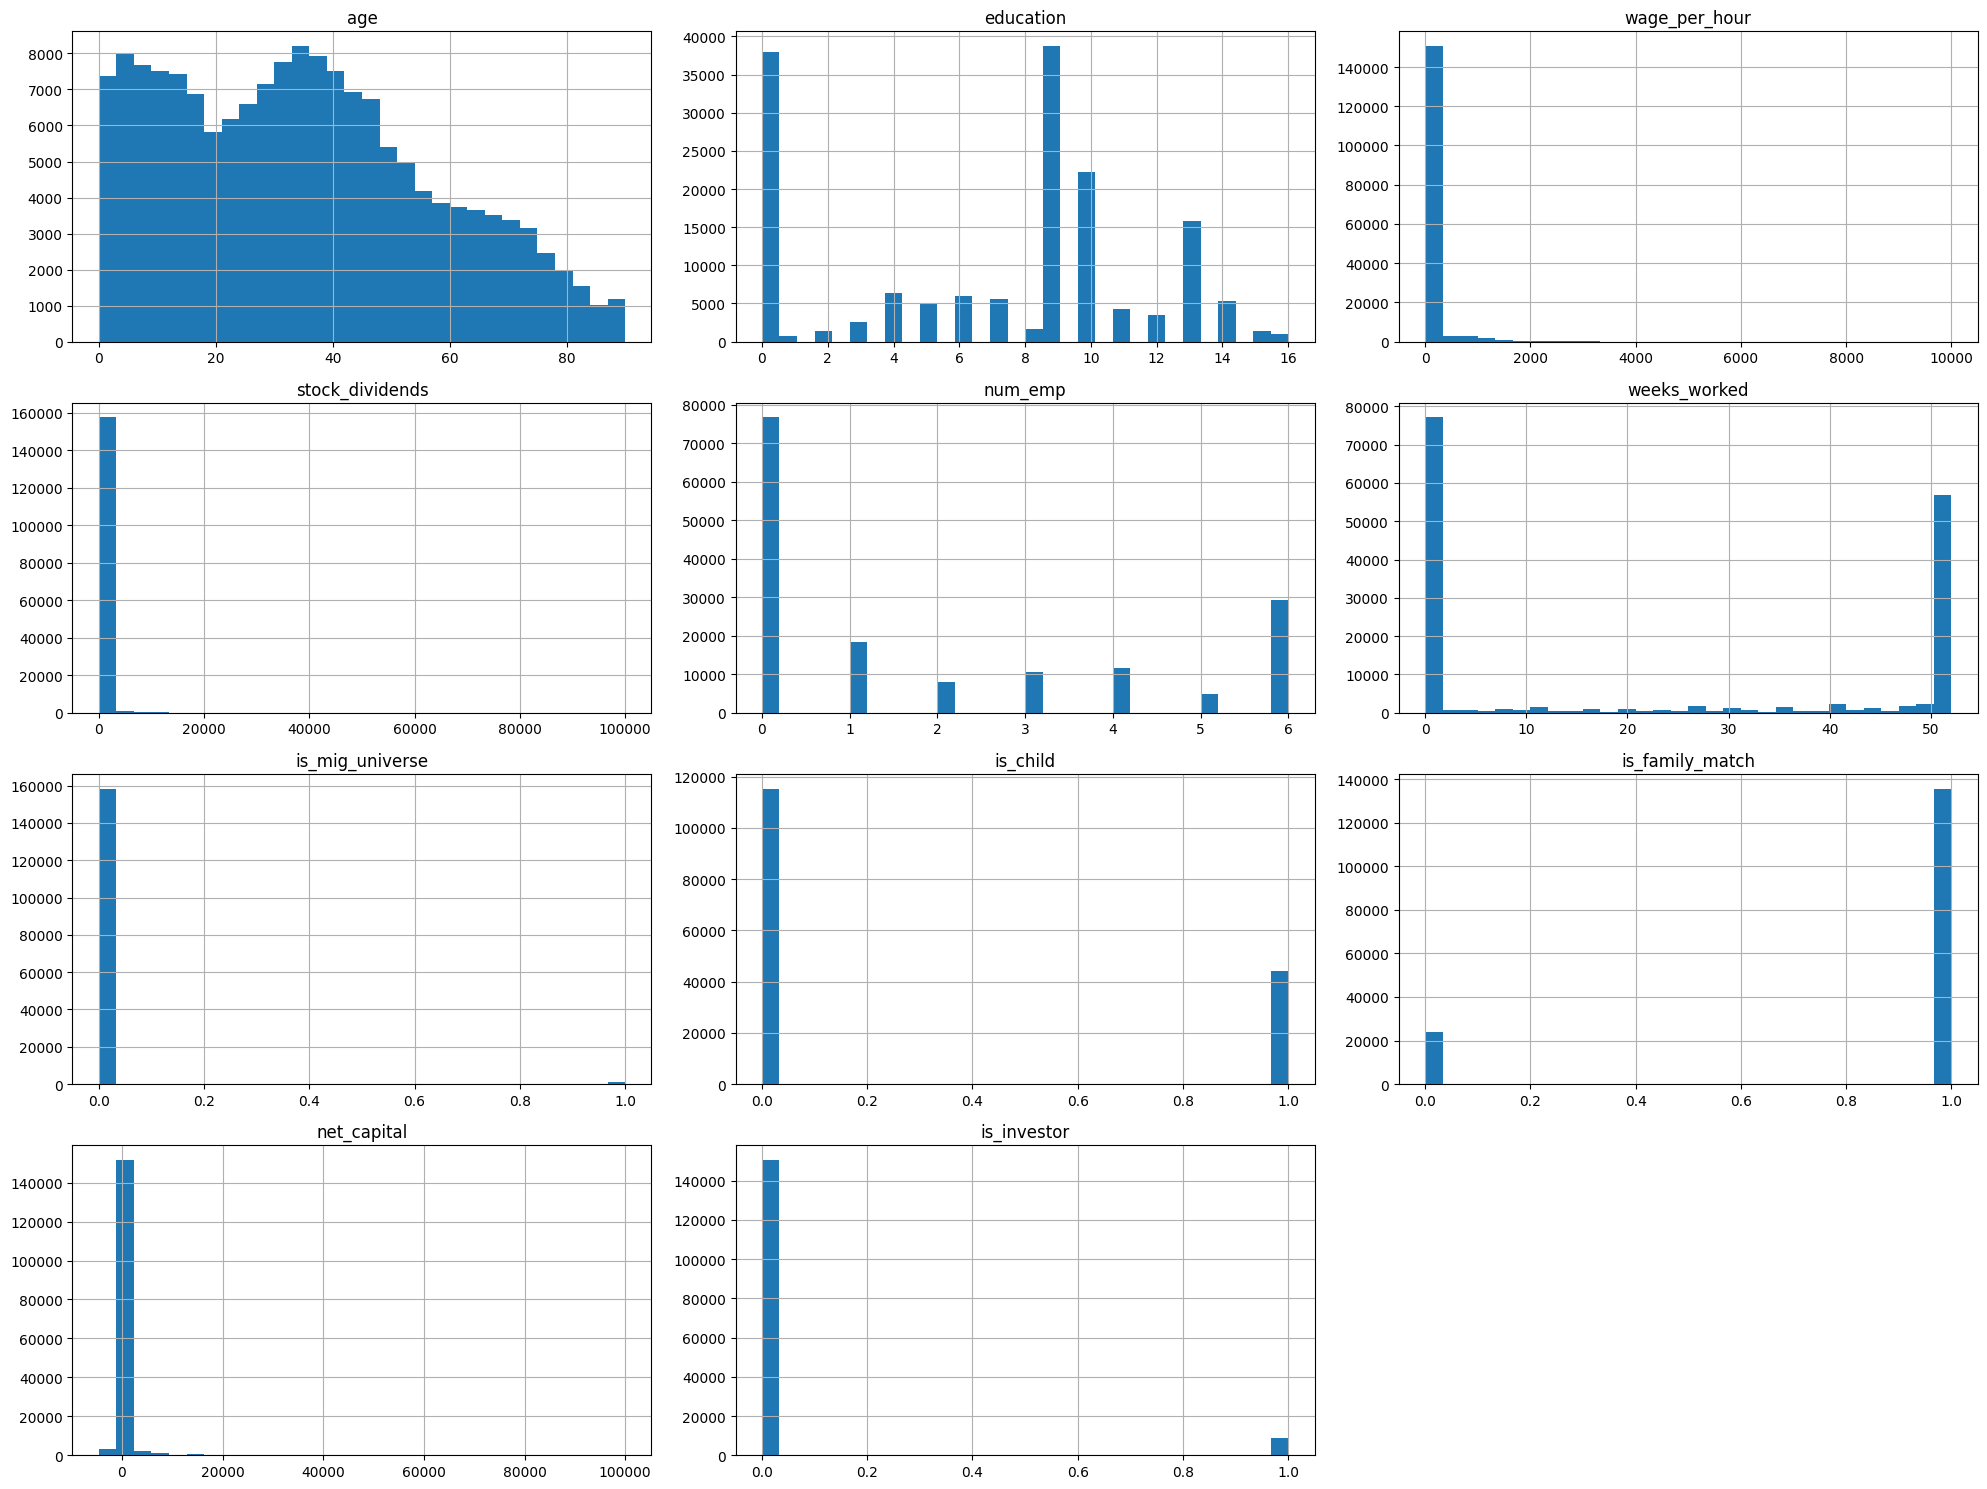

In [36]:
X_train.hist(bins=30, figsize=(20, 15))
plt.tight_layout() 
plt.show()

The dataset contains features with vastly different scales and distributions. For instance, `net_capital` spans hundreds of thousands with extreme outliers, while `age`and `education` vary within a much smaller range. Such disparities can bias the analysis, causing algorithms to overemphasize larger values.

To normalize the data, I will apply :
- Log-Transformation to compress the skewness in financial features
- Global Scaling ensuring equal weight for every feature.

In [37]:
skewed_features = ['wage_per_hour', 'stock_dividends', 'net_capital']

min_val = X_train['net_capital'].min()
shift = abs(min_val)
X_train['net_capital'] = X_train['net_capital'] + shift

X_train[skewed_features] = np.log1p(X_train[skewed_features])

all_num_features = ['wage_per_hour', 'stock_dividends', 'net_capital', 
                    'age', 'num_emp', 'weeks_worked', 'education']

scaler = StandardScaler()
X_train[all_num_features] = scaler.fit_transform(X_train[all_num_features])


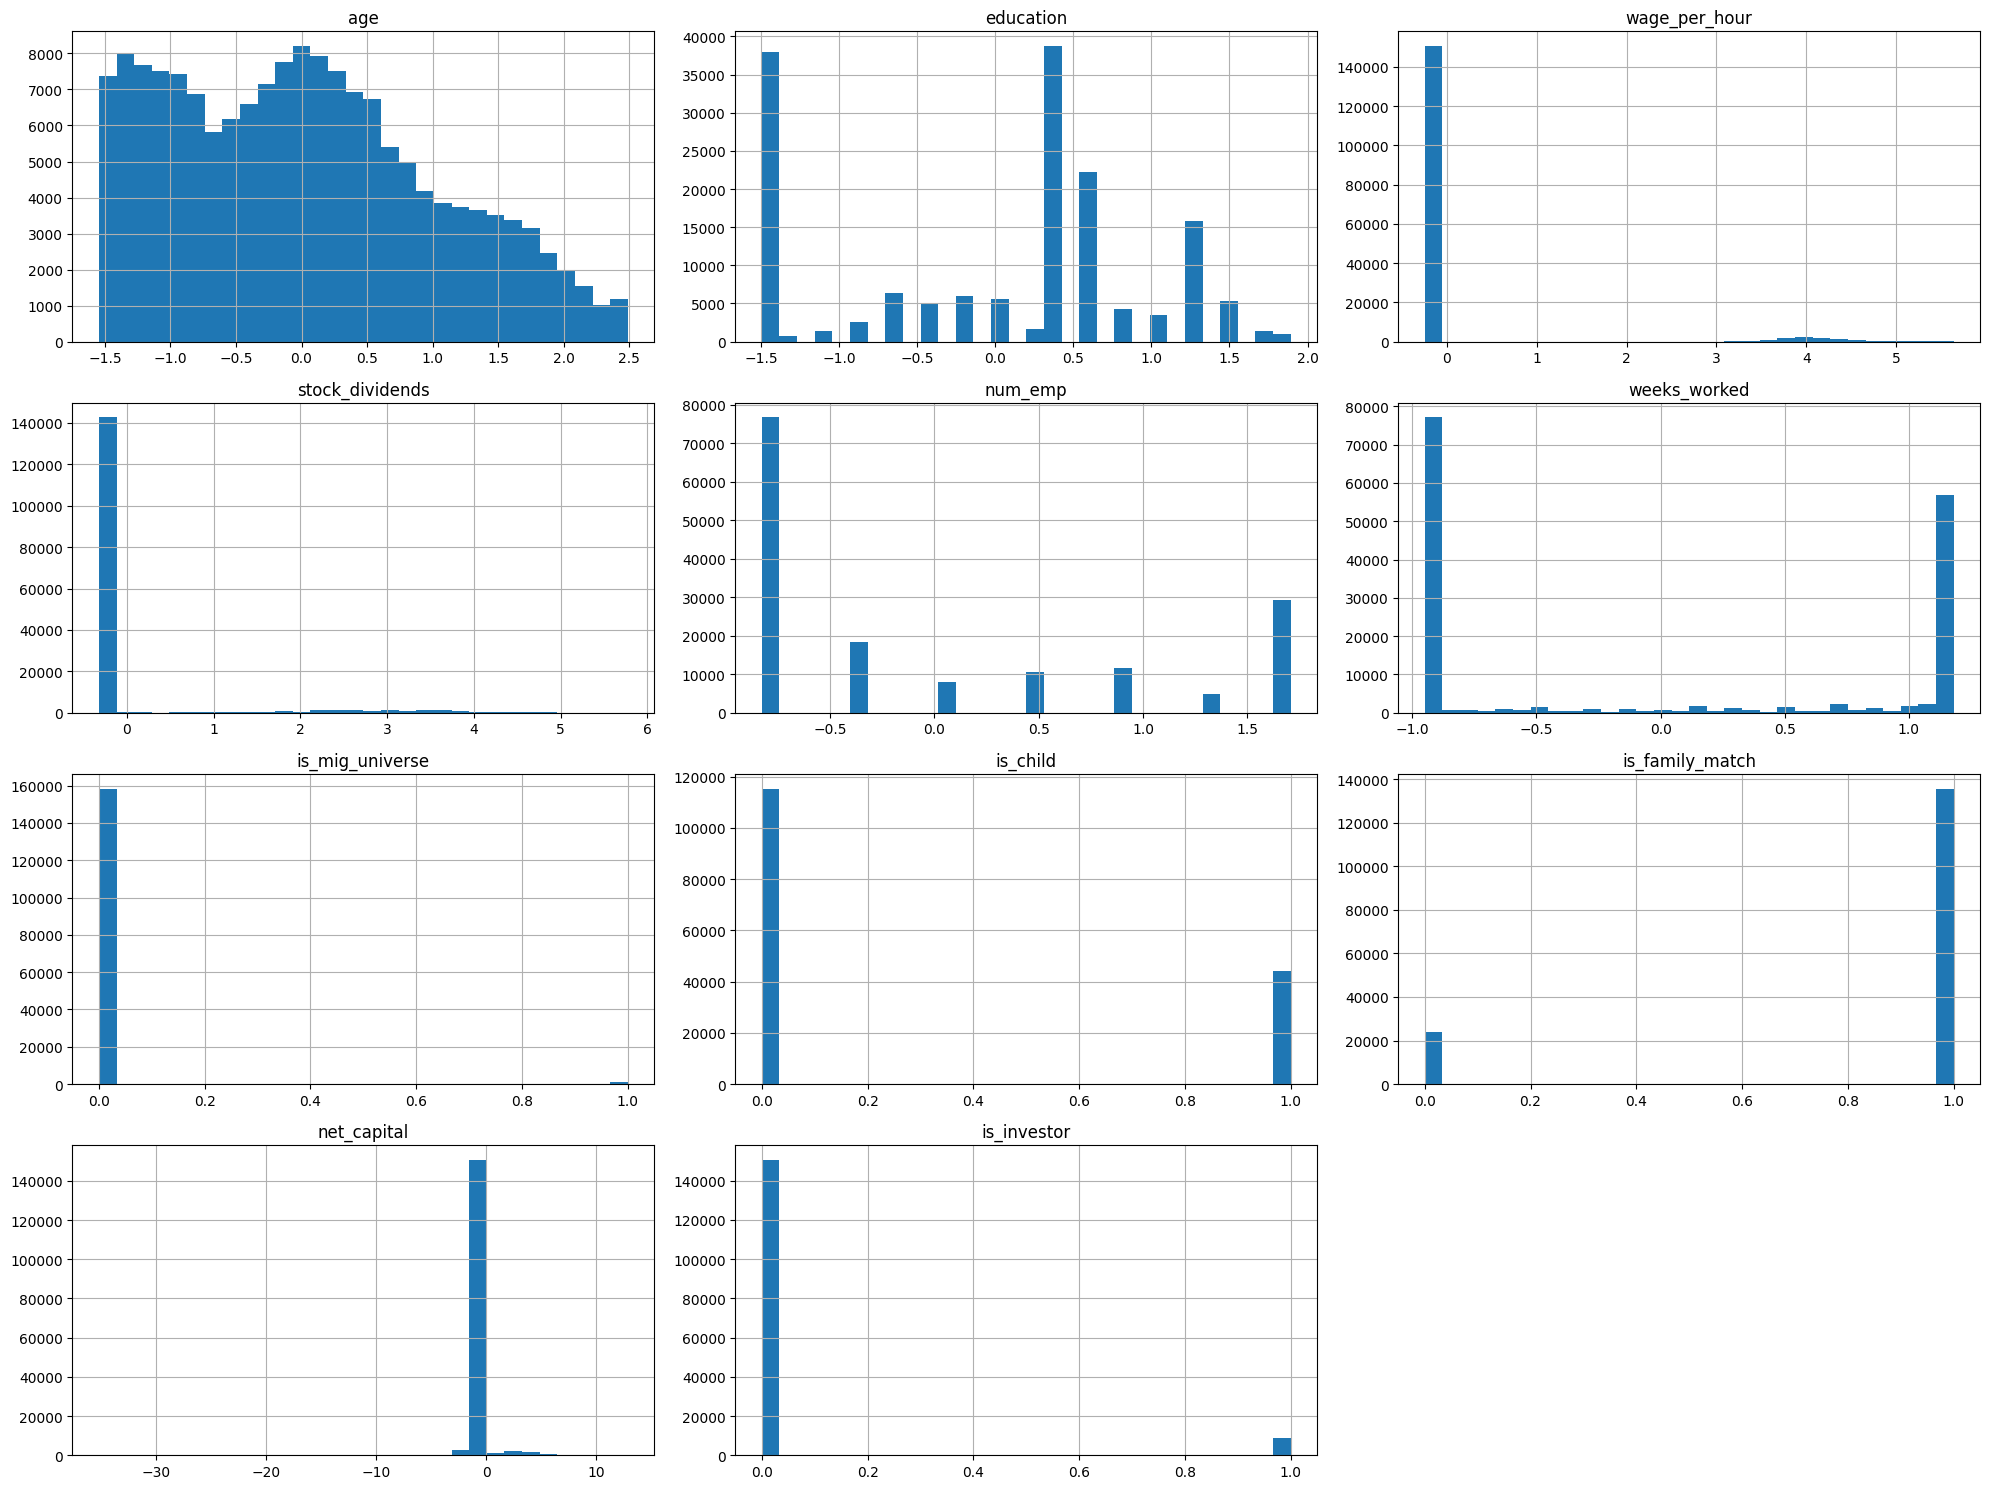

In [38]:
X_train.hist(bins=30, figsize=(20, 15))
plt.tight_layout() 
plt.show()

The resulting histograms confirm that the features are now standardized.

In [39]:
X_train.head()

,age,education,wage_per_hour,hs_college,marital_stat,union_member,stock_dividends,tax_filer_stat,mig_same,num_emp,...,is_child,is_family_match,net_capital,is_investor,industry_group,occupation_group,schedule_group,class_group,household_role,citizenship_group
19304,-1.365988,-1.495179,-0.244701,Not in universe,Never married,Not in universe,-0.321501,Nonfiler,Yes,-0.827535,...,1,1,-0.098247,0,Average_Yield,Minimal_Income,Children/Other,Non-Active,Dependent,US Native
190135,-1.052250,-1.495179,-0.244701,Not in universe,Never married,Not in universe,-0.321501,Nonfiler,Not in universe under 1 year old,-0.827535,...,1,1,-0.098247,0,Average_Yield,Minimal_Income,Children/Other,Non-Active,Dependent,US Native
103736,0.561259,1.257449,-0.244701,Not in universe,Widowed,Not in universe,-0.321501,Nonfiler,Not in universe under 1 year old,-0.827535,...,0,1,-0.098247,0,Average_Yield,Minimal_Income,Inactive,Non-Active,Householder,Naturalized
111242,0.785358,0.410486,-0.244701,Not in universe,Married-civilian spouse present,Not in universe,-0.321501,Joint both under 65,Not in universe under 1 year old,-0.404901,...,0,1,-0.098247,0,Low_Yield,Minimal_Income,Full-Time,Private,Spouse,US Native
41624,-1.052250,-1.495179,-0.244701,Not in universe,Never married,Not in universe,-0.321501,Nonfiler,Not in universe under 1 year old,-0.827535,...,1,1,-0.098247,0,Average_Yield,Minimal_Income,Children/Other,Non-Active,Dependent,US Native


## 6. Encoding Categorical Features

In [40]:
cat_columns = X_train.select_dtypes(include=['object']).columns
print(f"Columns to encode: {list(cat_columns)}")

X_train = pd.get_dummies(X_train, columns=cat_columns, drop_first=True)

Columns to encode: ['hs_college', 'marital_stat', 'union_member', 'tax_filer_stat', 'mig_same', 'industry_group', 'occupation_group', 'schedule_group', 'class_group', 'household_role', 'citizenship_group']


In [41]:
X_train.head()

,age,education,wage_per_hour,stock_dividends,num_emp,weeks_worked,is_mig_universe,is_child,is_family_match,net_capital,...,schedule_group_Part-Time,class_group_Non-Active,class_group_Private,class_group_Self-employed-incorporated,class_group_Self-employed-not incorporated,class_group_State-Local-Gov,household_role_Householder,household_role_Spouse,citizenship_group_Non-Citizen,citizenship_group_US Native
19304,-1.365988,-1.495179,-0.244701,-0.321501,-0.827535,-0.949845,0,1,1,-0.098247,...,False,True,False,False,False,False,False,False,False,True
190135,-1.052250,-1.495179,-0.244701,-0.321501,-0.827535,-0.949845,0,1,1,-0.098247,...,False,True,False,False,False,False,False,False,False,True
103736,0.561259,1.257449,-0.244701,-0.321501,-0.827535,-0.949845,0,0,1,-0.098247,...,False,True,False,False,False,False,True,False,False,False
111242,0.785358,0.410486,-0.244701,-0.321501,-0.404901,1.098298,0,0,1,-0.098247,...,False,False,True,False,False,False,False,True,False,True
41624,-1.052250,-1.495179,-0.244701,-0.321501,-0.827535,-0.949845,0,1,1,-0.098247,...,False,True,False,False,False,False,False,False,False,True


## 7. Final Pipeline

### Pipeline Steps Description

1. **`clean_strings_func`**
   - Strips whitespace and removes `"'"` characters from all object columns

2. **`engineer_features_func`**
   - **Clipping:** Caps `capital_gains` and `wage_per_hour`
   - **Creation:** Generates new features: `is_mig_universe`, `is_child`, `is_family_match`, `net_capital`, `is_investor`
   - **Dropping:** Removes redundant raw columns and sensitive features: `mig_chg_reg`, `mig_move_reg`, `mig_chg_msa`, `fam_under_18`, `country_father`, `country_mother`, `country_self`, `capital_gains`, `capital_losses`, `own_or_self`, `sex`, `race`, `hisp_origin`

3. **`group_categories_func`**
   - **Mapping:** Aggregates specific categories into broader groups: `industry_group`, `occupation_group`, `schedule_group`, `class_group`, `household_role`, `citizenship_group`
   - **Dropping:** Removes high-cardinality original columns: `major_ind_code`, `major_occ_code`, `full_or_part_emp`, `class_worker`, `det_hh_fam_stat`, `citizenship`

4. **`preprocessor` (ColumnTransformer)**
   - **Education:** Applies `OrdinalEncoder` (based on education hierarchy) followed by `StandardScaler`
   - **Skewed Features:** Applies custom `ShiftedLogTransformer` (handling negative values) followed by `StandardScaler` to: `wage_per_hour`, `stock_dividends`, `net_capital`
   - **Continuous:** Applies `StandardScaler` to: `age`, `num_emp`, `weeks_worked`
   - **Binary:** Passes through unchanged: `is_mig_universe`, `is_child`, `is_family_match`, `is_investor`
   - **Nominal:** Applies `OneHotEncoder` (drop='first') to: `hs_college`, `marital_stat`, `union_member`, `tax_filer_stat`, `mig_same`, `industry_group`, `occupation_group`, `schedule_group`, `class_group`, `household_role`, `citizenship_group`